In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset"

In [ ]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
import glob
import matplotlib.pyplot as plt
import cv2

In [ ]:
train = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Train" 
val ="/content/drive/MyDrive/COVID-19_Radiography_Dataset/Val"
test = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/Test"

gen_train = ImageDataGenerator(rescale = 1./255., zoom_range = 0.2,)
gen_val = ImageDataGenerator(rescale = 1./255.)
gen_test = ImageDataGenerator(rescale = 1./255.)

train_gen = gen_train.flow_from_directory(train, batch_size = 64, class_mode = 'categorical', target_size = (220, 220))
validation_gen = gen_val.flow_from_directory(val, batch_size = 64, class_mode = 'categorical', target_size=(220, 220))
test_gen = gen_test.flow_from_directory(test, shuffle = False, batch_size=64, class_mode = 'categorical', target_size=(220, 220))

Found 5786 images belonging to 2 classes.
Found 722 images belonging to 2 classes.
Found 722 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', input_shape=(220, 220, 3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,386,538
Trainable params: 525,058
Non-trainable params: 20,861,480
______________________________________

In [ ]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])
history = model.fit(train_gen, validation_data = validation_gen, steps_per_epoch = 32, epochs = 10)

Epoch 1/10
32/32 [==============================] - 1166s 37s/step - loss: 0.4154 - accuracy: 0.8091 - val_loss: 0.2993 - val_accuracy: 0.8560
Epoch 2/10
32/32 [==============================] - 387s 12s/step - loss: 0.3325 - accuracy: 0.8589 - val_loss: 0.3171 - val_accuracy: 0.8573
Epoch 3/10
32/32 [==============================] - 276s 9s/step - loss: 0.2986 - accuracy: 0.8735 - val_loss: 0.3111 - val_accuracy: 0.8435
Epoch 4/10
32/32 [==============================] - 192s 6s/step - loss: 0.3120 - accuracy: 0.8633 - val_loss: 0.3229 - val_accuracy: 0.8269
Epoch 5/10
32/32 [==============================] - 134s 4s/step - loss: 0.3049 - accuracy: 0.8622 - val_loss: 0.2139 - val_accuracy: 0.9030
Epoch 6/10
32/32 [==============================] - 82s 3s/step - loss: 0.2916 - accuracy: 0.8706 - val_loss: 0.2498 - val_accuracy: 0.8823
Epoch 7/10
32/32 [==============================] - 86s 3s/step - loss: 0.2846 - accuracy: 0.8794 - val_loss: 0.2538 - val_accuracy: 0.8740
Epoch 8/10
3

In [ ]:
model.save("Xception_model.h5")

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])
history1 = model.fit(train_gen, validation_data = validation_gen, steps_per_epoch = 32, epochs = 10, callbacks=[checkpoint])
best_model = model.load_weights('best_model.h5')

Epoch 1/10
32/32 [==============================] - 44s 1s/step - loss: 0.2559 - accuracy: 0.8896 - val_loss: 0.2526 - val_accuracy: 0.8753
Epoch 2/10
32/32 [==============================] - 43s 1s/step - loss: 0.2564 - accuracy: 0.8900 - val_loss: 0.2619 - val_accuracy: 0.8864
Epoch 3/10
32/32 [==============================] - 40s 1s/step - loss: 0.2427 - accuracy: 0.9019 - val_loss: 0.3051 - val_accuracy: 0.8573
Epoch 4/10
32/32 [==============================] - 39s 1s/step - loss: 0.2423 - accuracy: 0.8980 - val_loss: 0.2225 - val_accuracy: 0.8975
Epoch 5/10
32/32 [==============================] - 37s 1s/step - loss: 0.2394 - accuracy: 0.8970 - val_loss: 0.1254 - val_accuracy: 0.9474
Epoch 6/10
32/32 [==============================] - 40s 1s/step - loss: 0.2335 - accuracy: 0.9020 - val_loss: 0.4019 - val_accuracy: 0.8130
Epoch 7/10
32/32 [==============================] - 34s 1s/step - loss: 0.2400 - accuracy: 0.8925 - val_loss: 0.2245 - val_accuracy: 0.9017
Epoch 8/10
32/32 [==

In [ ]:
model.save("Xception_model1.h5")

In [ ]:
import pickle
with open('history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
loss, accuracy = model.evaluate(test_gen)

# print the loss and accuracy values
print('Test loss:', loss)
print('Test accuracy:', accuracy)

12/12 [==============================] - 4s 295ms/step - loss: 0.3572 - accuracy: 0.8393
Test loss: 0.3571702837944031
Test accuracy: 0.8393352031707764


In [ ]:
loss, accuracy = model.evaluate(train_gen)

# print the loss and accuracy values
print('Train loss:', loss)
print('Train accuracy:', accuracy)

91/91 [==============================] - 86s 944ms/step - loss: 0.3013 - accuracy: 0.8566
Train loss: 0.30134332180023193
Train accuracy: 0.8565502762794495


In [ ]:
loss, accuracy = model.evaluate(validation_gen)

# print the loss and accuracy values
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

12/12 [==============================] - 4s 292ms/step - loss: 0.1254 - accuracy: 0.9474
Validation loss: 0.12541070580482483
Validation accuracy: 0.9473684430122375


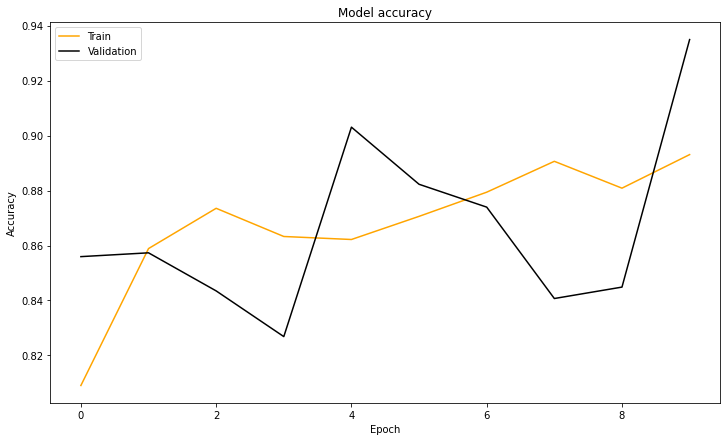

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(history.history['accuracy'], c = "orange")
ax.plot(history.history['val_accuracy'], c = "black")
ax.set_title('Model accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

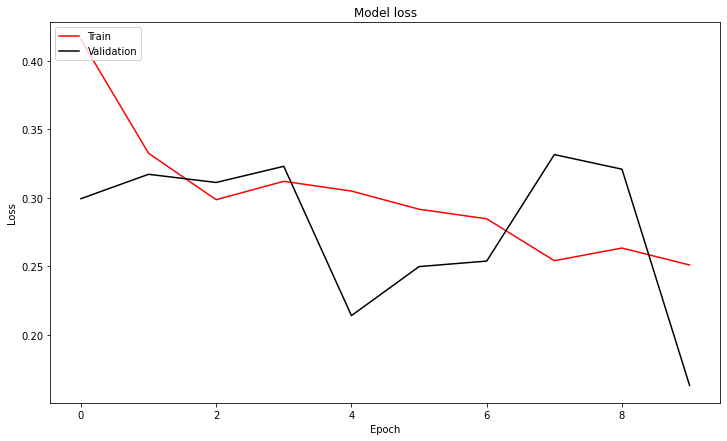

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(history.history['loss'], c ="red")
ax.plot(history.history['val_loss'], c = "black")
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()